In [1]:
#simple trial, batch size =1, 
import importlib
import id_utils6
from id_utils6 import choosePruneMethod



import argparse
import copy
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import nn_utils
from nn_utils import train, test, load_model
from fc import FC2, FC1
from id_utils import pruneID, compare_prune, getID
from data_utils import fashionmnist_loader, cifar10_loader
from plt_utils import plt_IDerr
import torch.nn.utils.prune as prune
import torch
import torchvision
import torchvision.transforms as transforms
from train import model_summary
import matplotlib.pyplot as plt
import numpy as np
import os
#os.environ["CUDA_LAUNCH_BLOCKING"]='0'
# functions to show an image
%matplotlib inline
trial=2
torch.manual_seed(trial)
np.random.seed(trial)


import scipy
import matplotlib.pyplot as plt 
%matplotlib inline
import torch.nn.functional as F
class arguments():
    def __init__(self):
        self.batch_size=64
        self.test_batch_size=500
        self.lr=.2
        self.epochs=200
        self.log_interval=10
        self.verbose=False
        self.prune_batch_size=1000
        self.dataset="cifar10"
        self.use_valid=True
        self.ft_proportion=0
        self.fine_tune=False
        self.arch="VGG16"
        self.load_fname="vgg16_epo160_seed2_best.pt"
args=arguments()
args.k_args="fracSkipIter"
args.skip=[]

model=load_model(args)
seed=4
torch.manual_seed(seed)
np.random.seed(seed)
train_loader, test_loader, prune_loader=cifar10_loader(args)

args.pruner="id"
args.pruner_args="Zorig"
#args.k_args="frac"
args.saveR=False
X_prune, y_prune = next(iter(prune_loader))



print(y_prune)
# print(X_prune.shape)
indx=np.where(y_prune!=0)[0]
# print(indx)
X_prune=(X_prune[indx, :,:,:])
y_prune=y_prune[indx]
print(y_prune)
# indx=np.where(y_prune!=9)[0]
# print(indx)
# X_prune=(X_prune[indx, :,:,:])
# print(X_prune.shape)

Files already downloaded and verified
Files already downloaded and verified
training/ft length: 50000
pruning length: 1000
test length: 9000
tensor([5, 9, 2, 5, 2, 4, 0, 8, 0, 9, 2, 7, 6, 5, 1, 2, 5, 2, 5, 0, 8, 6, 0, 5,
        6, 2, 6, 3, 3, 2, 2, 2, 2, 7, 6, 0, 4, 1, 9, 0, 2, 8, 3, 7, 9, 5, 9, 9,
        1, 2, 3, 0, 1, 8, 1, 9, 8, 7, 2, 2, 1, 6, 4, 7, 0, 2, 4, 1, 3, 2, 3, 3,
        2, 9, 3, 0, 0, 4, 3, 3, 7, 2, 4, 3, 1, 4, 9, 4, 5, 6, 9, 5, 3, 8, 4, 4,
        4, 9, 7, 4, 4, 0, 8, 5, 9, 8, 3, 0, 4, 6, 2, 5, 5, 7, 9, 2, 0, 4, 9, 6,
        8, 1, 2, 6, 1, 8, 0, 0, 6, 8, 9, 5, 0, 7, 6, 4, 1, 3, 7, 6, 6, 0, 0, 9,
        3, 6, 6, 2, 2, 9, 3, 9, 1, 5, 2, 4, 7, 6, 8, 6, 9, 0, 8, 1, 2, 8, 2, 0,
        2, 6, 2, 0, 2, 6, 0, 7, 1, 6, 9, 8, 8, 5, 7, 2, 3, 7, 4, 7, 7, 3, 3, 8,
        4, 5, 2, 2, 4, 8, 6, 0, 1, 4, 1, 3, 7, 6, 7, 9, 4, 9, 7, 2, 7, 9, 7, 4,
        3, 5, 1, 2, 0, 7, 6, 9, 2, 0, 2, 7, 6, 9, 1, 7, 1, 4, 0, 6, 3, 9, 2, 4,
        7, 4, 8, 8, 2, 1, 4, 7, 4, 1, 3, 6, 1, 3, 8, 4, 6, 

In [2]:
def softmax(i, t=1.0):
    ex = torch.exp(i/t)
    s = torch.sum(ex, axis=0)
    return ex / s

def cross_entropy(distribution, target, t=1.0):
    target=softmax(target)
    distribution=softmax(distribution)
    return -torch.sum(target * torch.log(distribution))/1000
    

def distill(args, model, device, train_loader, criterion, optimizer, epoch, alpha=.1, T=1):
    model.train()
    avg_loss = 0
    correct_1, correct_5, total = 0, 0, 0
    for data, target in train_loader:
        target1=model_full(data)
        data   = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss+=alpha*cross_entropy(output, target1, t=T)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()


    avg_loss /= len(train_loader) # over num batches

    return avg_loss

def test(args, model, device, test_loader, criterion, epoch, returnAcc=False, pstatement="Test"):
    model.eval()
    model=model.cuda()
    test_loss = 0
    correlation=0
    correct_1, correct_5, total = 0, 0, 0
    classes=np.zeros(10)
    allEx=np.zeros(10)
    with torch.no_grad():
        for data, target in test_loader:

            data  = data.cuda()
            target = target.cuda()
            output = model(data)
            with torch.no_grad():
                original=model_full(data)
                labels=original.argmax(dim=1, keepdim=True)
            
            if args.dataset == "fashion-mnist" \
                    or args.dataset == "cifar10":
                test_loss += criterion(output, target).item()  
                pred = output.argmax(dim=1, keepdim=True)  

                correlation+=(np.sum(pred.cpu().numpy()==labels.cpu().numpy()))

                correct_1 += pred.eq(target.view_as(pred)).sum().item()
                
                #print()
                #print(target.flatten())
                right=target.flatten()[pred.eq(target.view_as(pred)).flatten()]
                classes+=(torch.bincount(right, minlength=10)).cpu().numpy()
                allEx+=(torch.bincount(target, minlength=10)).cpu().numpy()
                
            total += len(target)
    test_loss /= len(test_loader) # over num batches
    print(allEx)
    print(classes)
    if epoch % args.log_interval == 0 and args.verbose:
        if args.dataset == "patches":
            print('{:s}: \t\t\tAvg Loss: {:f}\n'.format(pstatement, test_loss), flush=True)
        elif args.dataset == "fashion-mnist" or args. dataset == "cifar10":
            print('{:s}: Avg loss: {:f}, Accuracy: {}/{} ({:.1f}%) Top5 Accuracy: {}/{} ({:.1f}%)'.\
                    format(pstatement, 
                    test_loss, correct_1, total,
                    100. * correct_1 / total, 
                    correct_5, total,
                    100. * correct_5 / total),
                    flush=True)
    if returnAcc:
        return test_loss, correct_1 / total, correct_5 / total, correlation/total, allEx, classes
    return test_loss






In [3]:
import time 
start=time.time()
summary_input = (3,32,32)
model_full=model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.cuda()
from nn_utils import neuronnormNet, renormNet, load_model, save_checkpoint, print_model_param_nums, print_model_param_flops
X_prune, y_prune=X_prune.cuda(), y_prune.cuda()
torch.backends.cudnn.benchmark = False 
def model_summary(modelA, modelB=None, strA='', strB='',
        dataset='cifar10', summary_input=None, input_res=None, printParam=False):
        #print(strA)
        #torchsummary.summary(modelA, summary_input)
        #print("hi")
        if modelB is not None:
            #print(strB)
            torchsummary.summary(modelB, summary_input)
        if dataset == 'cifar10' or dataset == 'imagenet':
            print_model_param_nums(modelA)
            if modelB is not None:
                print_model_param_nums(modelB)
            if printParam:
                return (print_model_param_flops(modelA, input_res)) , (print_model_param_nums(modelA))
            return (print_model_param_flops(modelA, input_res))




ms, conv, lin=model_summary(model,summary_input= summary_input, input_res=32)
pruned=choosePruneMethod(args, model, X_prune, .90)
test(args, pruned, 'cpu', test_loader, criterion = nn.CrossEntropyLoss(), epoch=160, returnAcc=True)

criterion=nn.CrossEntropyLoss()

accuracy=[]
flopsct=[]
times=[]
it=0
while ms>627880970.0/8:
    
    pruned=choosePruneMethod(args, pruned, X_prune, .90)
    ms, conv, lin=model_summary(pruned,summary_input= summary_input, input_res=32)
    if it%5==0:
        flopsct.append(ms)
        accuracy.append(test(args, pruned, 'cpu', test_loader, criterion = nn.CrossEntropyLoss(), epoch=160, returnAcc=True))
        times.append(time.time()-start)
        print(accuracy)
    it+=1
print(test(args, pruned, 'cpu', test_loader, criterion = nn.CrossEntropyLoss(), epoch=160, returnAcc=True))





  + Number of params: 14.99M
  + Number of FLOPs: 0.62788G
  + Number of params: 14.99M
  + Number of FLOPs: 0.62788G
layers must be in forward pass order
[2.24872536e-27 1.26832898e-09 1.56989461e-09 2.07921888e-09
 2.52192122e-09 2.23138907e-09 1.59805535e-09 6.54250974e-10
 2.13498005e-10 8.52799395e-11 8.85563125e-11 3.66033310e-11
 9.98322405e-13 2.98092293e-11]
0
Conv-BN-Conv
[904. 912. 897. 901. 901. 910. 896. 894. 905. 880.]
[848. 881. 820. 774. 854. 817. 854. 857. 869. 842.]
  + Number of params: 14.98M
  + Number of FLOPs: 0.61921G
layers must be in forward pass order
[0.00000000e+00 1.36808519e-09 1.56989461e-09 2.07921866e-09
 2.52192122e-09 2.23138907e-09 1.59805535e-09 6.54250974e-10
 2.13498026e-10 8.52799066e-11 8.85562405e-11 3.66032333e-11
 9.98362959e-13 2.98108639e-11]
0
Conv-BN-Conv
  + Number of params: 14.98M
  + Number of FLOPs: 0.61179G
[904. 912. 897. 901. 901. 910. 896. 894. 905. 880.]
[848. 881. 820. 774. 854. 817. 854. 857. 869. 842.]
[(0.3223328176615033, 

[1.53806335e-10 1.69116817e-09 1.56989659e-09 2.07921932e-09
 2.52191749e-09 2.23138331e-09 1.59805151e-09 6.54248233e-10
 2.24918171e-10 1.28280539e-10 1.03747237e-10 1.06581846e-10
 1.03751036e-10 4.49480238e-10]
10
Conv-BN-Conv
  + Number of params: 11.83M
  + Number of FLOPs: 0.56831G
  + Number of params: 11.83M
  + Number of FLOPs: 0.56831G
layers must be in forward pass order
[1.53806335e-10 1.69116817e-09 1.56989659e-09 2.07921932e-09
 2.52191749e-09 2.23138331e-09 1.59805151e-09 6.54248233e-10
 2.24918171e-10 1.30940263e-10 1.59871203e-10 1.15015434e-10
 1.03780744e-10 4.49217236e-10]
12
Conv-BN-FC
  + Number of params: 11.75M
  + Number of FLOPs: 0.56770G
  + Number of params: 11.75M
  + Number of FLOPs: 0.56770G
layers must be in forward pass order
[1.53806335e-10 1.69116817e-09 1.56989659e-09 2.07921932e-09
 2.52191749e-09 2.23138331e-09 1.59805151e-09 6.54248233e-10
 2.24918171e-10 1.30940263e-10 1.59871203e-10 1.18632272e-10
 1.47032498e-10 4.96700822e-10]
11
Conv-BN-Conv

[4.64918172e-10 1.79066955e-09 1.56989220e-09 2.07920594e-09
 2.52190718e-09 2.23137788e-09 1.59802180e-09 7.01760939e-10
 3.47416084e-10 3.51163626e-10 4.23554758e-10 4.48042645e-10
 4.20005755e-10 5.97899522e-10]
8
Conv-BN-Conv
  + Number of params: 8.49M
  + Number of FLOPs: 0.50499G
  + Number of params: 8.49M
  + Number of FLOPs: 0.50499G
layers must be in forward pass order
[4.64918172e-10 1.79066955e-09 1.56989220e-09 2.07920594e-09
 2.52190718e-09 2.23137788e-09 1.59802180e-09 7.49941541e-10
 4.48208883e-10 3.82582702e-10 4.23043259e-10 4.47274012e-10
 4.19419803e-10 5.96623296e-10]
9
Conv-BN-Conv
  + Number of params: 8.25M
  + Number of FLOPs: 0.50002G
  + Number of params: 8.25M
  + Number of FLOPs: 0.50002G
layers must be in forward pass order
[4.64918172e-10 1.79066955e-09 1.56989220e-09 2.07920594e-09
 2.52190718e-09 2.23137788e-09 1.59802180e-09 7.49941541e-10
 4.66976250e-10 4.81546428e-10 4.48561641e-10 4.46968220e-10
 4.17430819e-10 5.99873000e-10]
12
Conv-BN-FC
  + N

[1.14571760e-09 1.90319398e-09 1.56983529e-09 2.07928577e-09
 2.52218921e-09 2.23154943e-09 1.59793002e-09 8.51578430e-10
 7.77833830e-10 7.49725472e-10 9.00589053e-10 9.50520788e-10
 9.68345831e-10 7.46020777e-10]
13
FC-BN-FC
  + Number of params: 6.84M
  + Number of FLOPs: 0.46773G
  + Number of params: 6.84M
  + Number of FLOPs: 0.46773G
layers must be in forward pass order
[1.14571760e-09 1.90319398e-09 1.56983529e-09 2.07928577e-09
 2.52218921e-09 2.23154943e-09 1.59793002e-09 8.51578430e-10
 7.77833830e-10 7.49725472e-10 9.00589053e-10 9.50520788e-10
 9.73759707e-10 1.79584847e-09]
9
Conv-BN-Conv
  + Number of params: 6.69M
  + Number of FLOPs: 0.46455G
  + Number of params: 6.69M
  + Number of FLOPs: 0.46455G
layers must be in forward pass order
[1.14571760e-09 1.90319398e-09 1.56983529e-09 2.07928577e-09
 2.52218921e-09 2.23154943e-09 1.59793002e-09 8.51578430e-10
 8.05650404e-10 9.37519384e-10 9.53805266e-10 9.49778563e-10
 9.72025665e-10 1.81831800e-09]
8
Conv-BN-Conv
  + Num

[1.79016791e-09 2.02381133e-09 1.56630900e-09 2.07799342e-09
 2.52122208e-09 2.22991041e-09 1.65395464e-09 1.31613615e-09
 1.36564611e-09 1.39272126e-09 1.32191493e-09 1.36881144e-09
 1.44840601e-09 1.94745413e-09]
7
Conv-BN-Conv
  + Number of params: 5.44M
  + Number of FLOPs: 0.42661G
  + Number of params: 5.44M
  + Number of FLOPs: 0.42661G
layers must be in forward pass order
[1.79016791e-09 2.02381133e-09 1.56630900e-09 2.07799342e-09
 2.52122208e-09 2.22991041e-09 1.70686278e-09 1.67552661e-09
 1.46356536e-09 1.39134747e-09 1.31430507e-09 1.36680291e-09
 1.45429554e-09 1.96710726e-09]
10
Conv-BN-Conv
  + Number of params: 5.34M
  + Number of FLOPs: 0.42581G
  + Number of params: 5.34M
  + Number of FLOPs: 0.42581G
layers must be in forward pass order
[1.79016791e-09 2.02381133e-09 1.56630900e-09 2.07799342e-09
 2.52122208e-09 2.22991041e-09 1.70686278e-09 1.67552661e-09
 1.46356536e-09 1.41974232e-09 1.68245886e-09 1.47358343e-09
 1.45749494e-09 1.96418066e-09]
9
Conv-BN-Conv
  +

[1.79016791e-09 2.13971242e-09 1.95995229e-09 2.21911109e-09
 2.50266814e-09 2.33800473e-09 2.11904350e-09 1.86606715e-09
 1.85751116e-09 1.92635403e-09 1.84612294e-09 1.89199800e-09
 2.29682742e-09 2.16098792e-09]
0
Conv-BN-Conv
  + Number of params: 4.83M
  + Number of FLOPs: 0.39232G
  + Number of params: 4.83M
  + Number of FLOPs: 0.39232G
layers must be in forward pass order
[2.97972505e-09 2.25277686e-09 1.95910028e-09 2.21661718e-09
 2.50293569e-09 2.33797684e-09 2.11939326e-09 1.86799574e-09
 1.85884149e-09 1.92606380e-09 1.84380757e-09 1.89285176e-09
 2.28671307e-09 2.16385611e-09]
10
Conv-BN-Conv
  + Number of params: 4.74M
  + Number of FLOPs: 0.39165G
  + Number of params: 4.74M
  + Number of FLOPs: 0.39165G
layers must be in forward pass order
[2.97972505e-09 2.25277686e-09 1.95910028e-09 2.21661718e-09
 2.50293569e-09 2.33797684e-09 2.11939326e-09 1.86799574e-09
 1.85884149e-09 1.96652732e-09 2.35701241e-09 2.04606072e-09
 2.28904201e-09 2.16812996e-09]
8
Conv-BN-Conv
  +

[2.97972505e-09 2.52264075e-09 2.83564905e-09 2.53384236e-09
 2.43975441e-09 2.41099545e-09 2.64434490e-09 2.61347393e-09
 2.50929740e-09 2.67469084e-09 2.49601020e-09 2.57542893e-09
 2.48344463e-09 4.58247889e-09]
5
Conv-BN-Conv
  + Number of params: 4.02M
  + Number of FLOPs: 0.33636G
  + Number of params: 4.02M
  + Number of FLOPs: 0.33636G
layers must be in forward pass order
[2.97972505e-09 2.52264075e-09 2.83564905e-09 2.53384236e-09
 2.61694327e-09 2.90447144e-09 2.87013401e-09 2.57539971e-09
 2.47342569e-09 2.66698515e-09 2.45132136e-09 2.62409009e-09
 2.50775331e-09 4.57323951e-09]
10
Conv-BN-Conv
  + Number of params: 3.96M
  + Number of FLOPs: 0.33583G
  + Number of params: 3.96M
  + Number of FLOPs: 0.33583G
layers must be in forward pass order
[2.97972505e-09 2.52264075e-09 2.83564905e-09 2.53384236e-09
 2.61694327e-09 2.90447144e-09 2.87013401e-09 2.57539971e-09
 2.47342569e-09 2.72192304e-09 3.10982518e-09 2.82679709e-09
 2.50595162e-09 4.57808174e-09]
8
Conv-BN-Conv
  +

[3.32735964e-09 3.36552388e-09 3.16358960e-09 3.18693362e-09
 3.23148383e-09 3.17510154e-09 3.53718026e-09 3.57269078e-09
 3.23616884e-09 3.00804297e-09 3.78331422e-09 3.15990793e-09
 3.59594184e-09 5.22950664e-09]
9
Conv-BN-Conv
  + Number of params: 3.34M
  + Number of FLOPs: 0.29259G
  + Number of params: 3.34M
  + Number of FLOPs: 0.29259G
layers must be in forward pass order
[3.32735964e-09 3.36552388e-09 3.16358960e-09 3.18693362e-09
 3.23148383e-09 3.17510154e-09 3.53718026e-09 3.57269078e-09
 3.35456526e-09 3.69859900e-09 3.99343219e-09 3.15170235e-09
 3.57798608e-09 5.27183841e-09]
11
Conv-BN-Conv
  + Number of params: 3.30M
  + Number of FLOPs: 0.29230G
  + Number of params: 3.30M
  + Number of FLOPs: 0.29230G
layers must be in forward pass order
[3.32735964e-09 3.36552388e-09 3.16358960e-09 3.18693362e-09
 3.23148383e-09 3.17510154e-09 3.53718026e-09 3.57269078e-09
 3.35456526e-09 3.69859900e-09 4.20641524e-09 4.04007084e-09
 3.97493570e-09 5.30142876e-09]
2
Conv-BN-Conv
  +

[4.94437285e-09 4.65684350e-09 4.26184529e-09 4.17834987e-09
 4.13505565e-09 3.78307196e-09 3.87018734e-09 4.59500312e-09
 4.23161235e-09 4.00641118e-09 3.86011314e-09 4.04265502e-09
 3.99112131e-09 5.26706621e-09]
5
Conv-BN-Conv
  + Number of params: 2.82M
  + Number of FLOPs: 0.23345G
  + Number of params: 2.82M
  + Number of FLOPs: 0.23345G
layers must be in forward pass order
[4.94437285e-09 4.65684350e-09 4.26184529e-09 4.17834987e-09
 4.43552682e-09 4.46762996e-09 4.20716439e-09 4.47476088e-09
 4.14109775e-09 3.95124967e-09 3.79231199e-09 4.04663039e-09
 4.07389532e-09 5.52617918e-09]
10
Conv-BN-Conv
  + Number of params: 2.77M
  + Number of FLOPs: 0.23306G
  + Number of params: 2.77M
  + Number of FLOPs: 0.23306G
layers must be in forward pass order
[4.94437285e-09 4.65684350e-09 4.26184529e-09 4.17834987e-09
 4.43552682e-09 4.46762996e-09 4.20716439e-09 4.47476088e-09
 4.14109775e-09 4.03375836e-09 4.80309397e-09 4.35525401e-09
 4.06475225e-09 5.52135391e-09]
9
Conv-BN-Conv
  +

[4.94437285e-09 4.91716394e-09 5.54261553e-09 5.47089208e-09
 4.77931191e-09 5.22483624e-09 5.35006562e-09 4.74081575e-09
 4.97813379e-09 5.40788347e-09 5.04056957e-09 5.91854975e-09
 6.50267579e-09 6.40328399e-09]
7
Conv-BN-Conv
  + Number of params: 2.33M
  + Number of FLOPs: 0.19998G
  + Number of params: 2.33M
  + Number of FLOPs: 0.19998G
layers must be in forward pass order
[4.94437285e-09 4.91716394e-09 5.54261553e-09 5.47089208e-09
 4.77931191e-09 5.22483624e-09 5.52117646e-09 5.70194704e-09
 5.31606834e-09 5.40386236e-09 4.99516161e-09 5.90121890e-09
 6.47833230e-09 6.43231789e-09]
4
Conv-BN-Conv
  + Number of params: 2.28M
  + Number of FLOPs: 0.19371G
  + Number of params: 2.28M
  + Number of FLOPs: 0.19371G
layers must be in forward pass order
[4.94437285e-09 4.91716394e-09 5.54261553e-09 5.71124508e-09
 5.61490702e-09 5.48046961e-09 5.39732670e-09 5.55161171e-09
 5.17374241e-09 5.38700116e-09 4.92092206e-09 5.92283966e-09
 6.51972305e-09 6.35635393e-09]
1
Conv-BN-Conv
  + 

[904. 912. 897. 901. 901. 910. 896. 894. 905. 880.]
[788. 835. 728. 758. 812. 657. 832. 772. 823. 815.]
[(0.3223328176615033, 0.9351111111111111, 0.0, 1.0, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.32303940763710237, 0.935, 0.0, 0.9998888888888889, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 880., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.3227839420107028, 0.9351111111111111, 0.0, 0.9998888888888889, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.3229790640010743, 0.9351111111111111, 0.0, 0.9998888888888889, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.32257932032200887, 0.9351111111111111, 0.0, 0.9997777777777778, array([904., 912., 897., 901., 901.

[8.20440751e-09 7.10781149e-09 7.54385296e-09 7.50959102e-09
 7.01285719e-09 6.60613812e-09 7.10830641e-09 7.46156923e-09
 6.66318615e-09 7.30326593e-09 7.82157583e-09 6.91546124e-09
 6.92638434e-09 6.83838957e-09]
5
Conv-BN-Conv
  + Number of params: 1.73M
  + Number of FLOPs: 0.14700G
  + Number of params: 1.73M
  + Number of FLOPs: 0.14700G
layers must be in forward pass order
[8.20440751e-09 7.10781149e-09 7.54385296e-09 7.50959102e-09
 7.49761691e-09 7.69986554e-09 7.61915092e-09 7.01725351e-09
 6.56037783e-09 7.25134846e-09 7.68890797e-09 6.92954376e-09
 6.87862240e-09 7.08202768e-09]
8
Conv-BN-Conv
  + Number of params: 1.69M
  + Number of FLOPs: 0.14550G
  + Number of params: 1.69M
  + Number of FLOPs: 0.14550G
layers must be in forward pass order
[8.20440751e-09 7.10781149e-09 7.54385296e-09 7.50959102e-09
 7.49761691e-09 7.69986554e-09 7.61915092e-09 7.39724919e-09
 8.05647403e-09 7.91478390e-09 7.60061399e-09 6.89903846e-09
 6.86493699e-09 7.07953955e-09]
12
Conv-BN-FC
  + N

[9.15840838e-09 8.86845202e-09 8.42924285e-09 8.80412856e-09
 8.18454094e-09 8.52929880e-09 8.34964505e-09 7.97412044e-09
 8.32214352e-09 7.94027276e-09 7.66031466e-09 9.37187024e-09
 1.07448344e-08 8.00752222e-09]
10
Conv-BN-Conv
  + Number of params: 1.51M
  + Number of FLOPs: 0.13044G
  + Number of params: 1.51M
  + Number of FLOPs: 0.13044G
layers must be in forward pass order
[9.15840838e-09 8.86845202e-09 8.42924285e-09 8.80412856e-09
 8.18454094e-09 8.52929880e-09 8.34964505e-09 7.97412044e-09
 8.32214352e-09 8.10622702e-09 9.71035796e-09 1.00555837e-08
 1.07589729e-08 7.96059340e-09]
13
FC-BN-FC
  + Number of params: 1.50M
  + Number of FLOPs: 0.13044G
[904. 912. 897. 901. 901. 910. 896. 894. 905. 880.]
[770. 799. 605. 678. 792. 551. 823. 694. 828. 814.]
[(0.3223328176615033, 0.9351111111111111, 0.0, 1.0, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.32303940763710237, 0.935, 0.0, 0.

[9.15840838e-09 9.33172936e-09 1.02256928e-08 9.82920624e-09
 9.13509489e-09 9.03904312e-09 9.93536661e-09 9.41126145e-09
 8.76285279e-09 9.88540303e-09 9.65919018e-09 9.97584036e-09
 1.09107777e-08 1.44370800e-08]
8
Conv-BN-Conv
  + Number of params: 1.31M
  + Number of FLOPs: 0.11686G
  + Number of params: 1.31M
  + Number of FLOPs: 0.11686G
layers must be in forward pass order
[9.15840838e-09 9.33172936e-09 1.02256928e-08 9.82920624e-09
 9.13509489e-09 9.03904312e-09 9.93536661e-09 9.90261245e-09
 1.06584382e-08 1.07559228e-08 9.59482272e-09 9.94936620e-09
 1.08650805e-08 1.44731771e-08]
5
Conv-BN-Conv
  + Number of params: 1.28M
  + Number of FLOPs: 0.11259G
  + Number of params: 1.28M
  + Number of FLOPs: 0.11259G
layers must be in forward pass order
[9.15840838e-09 9.33172936e-09 1.02256928e-08 9.82920624e-09
 9.79120668e-09 1.05741417e-08 1.06586008e-08 9.17588446e-09
 1.03939292e-08 1.05829733e-08 9.22393906e-09 9.90981804e-09
 1.13555053e-08 1.45750633e-08]
0
Conv-BN-Conv
  + 

  + Number of params: 1.19M
  + Number of FLOPs: 0.10404G
  + Number of params: 1.19M
  + Number of FLOPs: 0.10404G
layers must be in forward pass order
[1.57653125e-08 1.26599393e-08 1.05835750e-08 1.00409686e-08
 1.12392121e-08 1.08745768e-08 1.07212928e-08 1.03897404e-08
 1.07557880e-08 1.06753622e-08 1.14711434e-08 1.03846747e-08
 1.15770092e-08 1.49711891e-08]
3
Conv-BN-Conv
  + Number of params: 1.17M
  + Number of FLOPs: 0.10065G
  + Number of params: 1.17M
  + Number of FLOPs: 0.10065G
layers must be in forward pass order
[1.57653125e-08 1.26599393e-08 1.14218780e-08 1.25056754e-08
 1.16714370e-08 1.04162111e-08 1.06731232e-08 1.01920873e-08
 1.06155861e-08 1.06545928e-08 1.13636796e-08 1.04913263e-08
 1.16583077e-08 1.48351625e-08]
7
Conv-BN-Conv
  + Number of params: 1.14M
  + Number of FLOPs: 0.09951G
  + Number of params: 1.14M
  + Number of FLOPs: 0.09951G
layers must be in forward pass order
[1.57653125e-08 1.26599393e-08 1.14218780e-08 1.25056754e-08
 1.16714370e-08 1.04

[1.57653125e-08 1.26599393e-08 1.14218780e-08 1.25056754e-08
 1.24639420e-08 1.21636363e-08 1.20227261e-08 1.33780916e-08
 1.20242081e-08 1.27593536e-08 1.17414894e-08 1.31477040e-08
 1.26658862e-08 1.49593490e-08]
2
Conv-BN-Conv
  + Number of params: 1.03M
  + Number of FLOPs: 0.09158G
  + Number of params: 1.03M
  + Number of FLOPs: 0.09158G
layers must be in forward pass order
[1.57653125e-08 1.32929363e-08 1.40955111e-08 1.31414500e-08
 1.17822946e-08 1.16425438e-08 1.19446390e-08 1.28601053e-08
 1.17810416e-08 1.26677118e-08 1.15327601e-08 1.32285951e-08
 1.29688462e-08 1.46756408e-08]
10
Conv-BN-Conv
  + Number of params: 1.01M
  + Number of FLOPs: 0.09142G
[904. 912. 897. 901. 901. 910. 896. 894. 905. 880.]
[661. 497. 459. 611. 740. 375. 824. 577. 724. 729.]
[(0.3223328176615033, 0.9351111111111111, 0.0, 1.0, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.32303940763710237, 0.935, 0.0,

  + Number of FLOPs: 0.08417G
  + Number of params: 0.91M
  + Number of FLOPs: 0.08417G
layers must be in forward pass order
[1.57653125e-08 1.32929363e-08 1.40955111e-08 1.37006606e-08
 1.45709253e-08 1.42537411e-08 1.28873315e-08 1.43438222e-08
 1.41673770e-08 1.36938693e-08 1.31751800e-08 1.38199703e-08
 1.30170185e-08 1.48305726e-08]
6
Conv-BN-Conv
  + Number of params: 0.89M
  + Number of FLOPs: 0.08231G
[904. 912. 897. 901. 901. 910. 896. 894. 905. 880.]
[642. 281. 419. 605. 703. 331. 825. 490. 675. 665.]
[(0.3223328176615033, 0.9351111111111111, 0.0, 1.0, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.32303940763710237, 0.935, 0.0, 0.9998888888888889, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 880., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.3227839420107028, 0.9351111111111111, 0.0, 0.9998888888888889, array([904., 912., 897., 901., 90

[904. 912. 897. 901. 901. 910. 896. 894. 905. 880.]
[601. 223. 399. 580. 703. 314. 824. 459. 640. 631.]
(1.8785910259747336, 0.5971111111111111, 0.0, 0.6021111111111112, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([601., 223., 399., 580., 703., 314., 824., 459., 640., 631.]))


In [4]:
print(accuracy)

[(0.3223328176615033, 0.9351111111111111, 0.0, 1.0, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.32303940763710237, 0.935, 0.0, 0.9998888888888889, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 880., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.3227839420107028, 0.9351111111111111, 0.0, 0.9998888888888889, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.3229790640010743, 0.9351111111111111, 0.0, 0.9998888888888889, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), (0.32257932032200887, 0.9351111111111111, 0.0, 0.9997777777777778, array([904., 912., 897., 901., 901., 910., 896., 894., 905., 880.]), array([848., 881., 820., 774., 854., 817., 854., 857., 869., 842.])), 

In [5]:
print(flopsct)

[611786762.0, 597612466.0, 587025986.0, 571585866.0, 552512914.0, 538996354.0, 516196866.0, 493202510.0, 469744998.0, 457155062.0, 444394246.0, 423709986.0, 396033706.0, 371209486.0, 350235822.0, 326017406.0, 293837614.0, 270500974.0, 242958670.0, 225174514.0, 202788942.0, 187024494.0, 166763230.0, 152476698.0, 141977686.0, 130438510.0, 117951102.0, 109513950.0, 96082398.0, 91420794.0, 82308010.0]


In [6]:
import pickle


In [7]:
file=open("savedSubAccs.p", 'wb')
pickle.dump((accuracy, flopsct), file)

In [8]:
file.close()

In [9]:
subacts=[]
for acc in accuracy:
    subacts.append(acc[5]/acc[4])

In [10]:
print(subacts)
subacts=np.array(subacts)
flopsct=np.array(flopsct)

[array([0.9380531 , 0.96600877, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96491228, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96600877, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96600877, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96600877, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96491228, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96132597, 0.95681818]), array([0.9380531 , 0.96491228, 0.91304348, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96132597, 0.95568182]), array([0.9380531 , 0.96491228, 0.91415831, 0.86

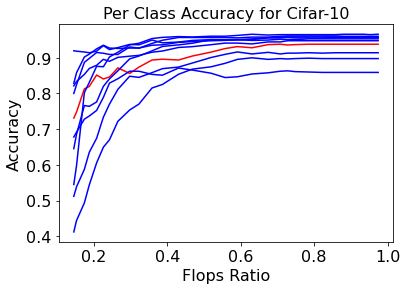

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
fs=16
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.plot(flopsct[:-1]/627880970.0,subacts[:-1, 0], 'r')
for i in range(1,10):
    plt.plot(flopsct[:-1]/627880970.0,subacts[:-1, i], 'b')
plt.title("Per Class Accuracy for Cifar-10", fontsize=fs)
plt.ylabel("Accuracy", fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlabel("Flops Ratio", fontsize=fs)
plt.show()


In [14]:
print(y_prune)

tensor([5, 9, 2, 5, 2, 4, 8, 9, 2, 7, 6, 5, 1, 2, 5, 2, 5, 8, 6, 5, 6, 2, 6, 3,
        3, 2, 2, 2, 2, 7, 6, 4, 1, 9, 2, 8, 3, 7, 9, 5, 9, 9, 1, 2, 3, 1, 8, 1,
        9, 8, 7, 2, 2, 1, 6, 4, 7, 2, 4, 1, 3, 2, 3, 3, 2, 9, 3, 4, 3, 3, 7, 2,
        4, 3, 1, 4, 9, 4, 5, 6, 9, 5, 3, 8, 4, 4, 4, 9, 7, 4, 4, 8, 5, 9, 8, 3,
        4, 6, 2, 5, 5, 7, 9, 2, 4, 9, 6, 8, 1, 2, 6, 1, 8, 6, 8, 9, 5, 7, 6, 4,
        1, 3, 7, 6, 6, 9, 3, 6, 6, 2, 2, 9, 3, 9, 1, 5, 2, 4, 7, 6, 8, 6, 9, 8,
        1, 2, 8, 2, 2, 6, 2, 2, 6, 7, 1, 6, 9, 8, 8, 5, 7, 2, 3, 7, 4, 7, 7, 3,
        3, 8, 4, 5, 2, 2, 4, 8, 6, 1, 4, 1, 3, 7, 6, 7, 9, 4, 9, 7, 2, 7, 9, 7,
        4, 3, 5, 1, 2, 7, 6, 9, 2, 2, 7, 6, 9, 1, 7, 1, 4, 6, 3, 9, 2, 4, 7, 4,
        8, 8, 2, 1, 4, 7, 4, 1, 3, 6, 1, 3, 8, 4, 6, 6, 8, 1, 9, 3, 7, 8, 8, 7,
        8, 9, 6, 2, 8, 7, 7, 5, 4, 5, 2, 3, 1, 5, 2, 7, 2, 9, 1, 6, 3, 7, 2, 7,
        5, 9, 3, 1, 1, 1, 7, 9, 9, 9, 3, 2, 1, 7, 5, 4, 6, 1, 1, 6, 1, 4, 7, 6,
        9, 9, 1, 5, 9, 2, 5, 5, 2, 6, 8,

In [3]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#file=open("perclass.p", 'wb')
file=open("perclass.p", 'rb')
accuracy,flopsct=pickle.load( file )
file.close()
subacts=[]
for acc in accuracy:
    subacts.append(acc[5]/acc[4])
print(subacts)
subacts=np.array(subacts)
flopsct=np.array(flopsct)

[array([0.9380531 , 0.96600877, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96491228, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96600877, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96600877, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96600877, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96022099, 0.95681818]), array([0.9380531 , 0.96491228, 0.91415831, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96132597, 0.95681818]), array([0.9380531 , 0.96491228, 0.91304348, 0.8590455 , 0.94783574,
       0.8978022 , 0.953125  , 0.95861298, 0.96132597, 0.95568182]), array([0.9380531 , 0.96491228, 0.91415831, 0.86

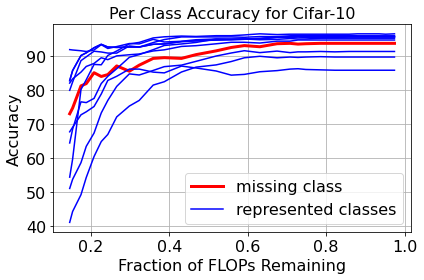

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
fs=16
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.plot(flopsct[:-1]/627880970.0,subacts[:-1, 0]*100, 'r', label="missing class", linewidth=3)
for i in range(1,10):
    plt.plot(flopsct[:-1]/627880970.0,subacts[:-1, i]*100, 'b')
plt.plot(flopsct[:-1]/627880970.0,subacts[:-1, i]*100, 'b', label="represented classes")
plt.title("Per Class Accuracy for Cifar-10", fontsize=fs)
plt.ylabel("Accuracy", fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.grid()
plt.xlabel("Fraction of FLOPs Remaining", fontsize=fs)
plt.legend(fontsize=fs)
plt.tight_layout()
plt.savefig("subclass.pdf")


[1.0, 0.9998888888888889, 0.9998888888888889, 0.9998888888888889, 0.9997777777777778, 0.9996666666666667, 0.9994444444444445, 0.9993333333333333, 0.9986666666666667, 0.998, 0.997, 0.9943333333333333, 0.9884444444444445, 0.9816666666666667, 0.9777777777777777, 0.9722222222222222, 0.9614444444444444, 0.9501111111111111, 0.9388888888888889, 0.9291111111111111, 0.9126666666666666, 0.9035555555555556, 0.887, 0.8664444444444445, 0.8532222222222222, 0.8313333333333334, 0.8033333333333333, 0.7857777777777778, 0.7201111111111111, 0.6968888888888889, 0.6313333333333333]


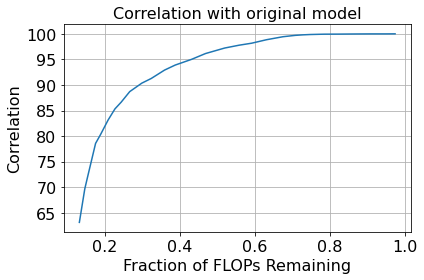

In [19]:
corr=[]
for i in accuracy:
    corr.append(i[3])
print(corr)
corr=np.array(corr)
fig=plt.figure()
fig.patch.set_facecolor('white')
plt.plot(flopsct/627880970.0, corr*100)
plt.ylabel("Correlation", fontsize=fs)
plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.xlabel("Fraction of FLOPs Remaining", fontsize=fs)
plt.grid()
plt.title("Correlation with original model", fontsize=fs)
plt.tight_layout()
plt.savefig("IDcorr.pdf")